# Using Pytorch to recreate AlexNet CNN Architecture - Testing Accuracy 86%

To classify the images, I coded the AlexNet architecture from scratch (refer to architecture here: https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/), slightly modified to classify for 6 classes instead of the original 1000 it was designed for.

I used a learning rate scheduler to avoid overshooting the loss minimum point when the model is getting very close to the minimum. I also used an early stopping mechanism (from https://github.com/Bjarten/early-stopping-pytorch#:~:text=Early%20stopping%20is%20a%20form,a%20row%20the%20training%20stops) to prevent overfitting of the model (defined as when validation loss starts to increase).

*A bit of detail about CNNs*:
CNNs consist of multiple convolutional layers, with fully connected layers to produce a final output. Each convolutional layer convolves over an image (in the form of 3 dimensional tensors) to produce feature maps which record particular features of an image (e.g. edges, colors). The feature maps are then flattened (rearranged to form a vector) as input to the fully connected layers. Dropout layers are used to avoid having many neurons be unused in the prediction process.

In [1]:
%matplotlib inline
#a script from https://github.com/Bjarten/early-stopping-pytorch#:~:text=Early%20stopping%20is%20a%20form,a%20row%20the%20training%20stops.
from early_stopping_script import EarlyStopping
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation

In [2]:
#pipeline to transform images into normalized tensors with mean and std at 0.5 for each
#color channel (3) for quicker learning
#resize to 300,300 which is the largest image in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)), 
    transforms.Resize((300,300))]
)

**Creating Train and Validation Dataloaders**

Validation set is created to evaluate the performance of the model in order to make adjustments to the architecture, hyperparameters etc., as well as to use the early stopping and learning rate scheduler tools. Testing set should not be used for these purposes to ensure the testing metrics are not overinflated.

In [3]:
#create dataset from image files
trainset = torchvision.datasets.ImageFolder(
    root='/kaggle/input/intel-image-classification/seg_train/seg_train', transform=transform)

#train-validation set split
#create shuffled indices for splitting into train-val for early stopping
indices = list(range(len(trainset)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[:round(len(trainset)*0.9)], indices[round(len(trainset)*0.9):]
#create samplers
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
#create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          num_workers=2,
                                         sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          num_workers=2,
                                       sampler=val_sampler)

In [4]:
#retrieve class names -- imageFolder creates its own labels
classes = trainset.class_to_idx
#create list so that class mapping is easier to access
classes = [class_name for (class_name, index) in classes.items()]
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

forest street forest mountain street


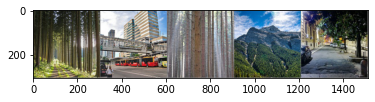

In [5]:
#print a batch of training images to test the dataloader
data_iter = iter(trainloader)
images, labels = data_iter.next()

def print_image(image):
    x = image/2 +0.5 #reverse normalization
    np_image = x.numpy() #convert to numpy for plt viz
    plt.imshow(np.transpose(np_image, (1, 2, 0))) #transpose to convert from tensor to numpy
    
# show images
print_image(torchvision.utils.make_grid(images[:5, :, :]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

**Creating test dataloader**

In [6]:
#load testing image dataset into dataloader
testset = torchvision.datasets.ImageFolder(
    root='/kaggle/input/intel-image-classification/seg_test/seg_test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True, num_workers=2)

street forest glacier   sea forest


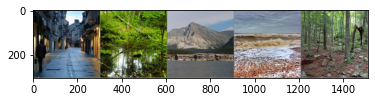

In [7]:
#print a batch of testing images
data_iter = iter(testloader)
images, labels = data_iter.next()
    
# show images
print_image(torchvision.utils.make_grid(images[:5, :, :]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

# Creating AlexNet

After each convolutional layer is applied to the input, reLU is used as the activation function, which speeds up computation. The second fully connected layer uses 1000 nodes as its output size, which is much larger than the original in AlexNet since the final layer consists 6 instead of 1000 classes.

In [8]:
class AlexNet(nn.Module):
    #replicating AlexNet, filter layers from below link
    #https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/
    def __init__(self):
        #initialise inherited methods and properties from nn Module
        super(AlexNet, self).__init__()
        #first convolutional layer - 96 filters, 11x11, stride 4
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4)
        #max pooling layer - 3x3, stride 2
        self.max1 = nn.MaxPool2d(3, stride=2)
        #second convolutional layer - 256 filters, 5x5, stride 1
        self.conv2 = nn.Conv2d(96, 256, 5)
        #second max pooling
        self.max2 = nn.MaxPool2d(3, stride=2)
        #third conv
        self.conv3 = nn.Conv2d(256, 384, 3)
        #fourth conv
        self.conv4 = nn.Conv2d(384, 384, 3)
        #fifth conv
        self.conv5 = nn.Conv2d(384, 256, 3)
        #max pool 3 - adaptive used to adjust the size of the map to 6x6x256
        self.max3 = nn.AdaptiveMaxPool2d(6)
        #dropout
        self.drop1 = nn.Dropout(p=0.5)
        #flatten
        self.flat = nn.Flatten()
        #FC1
        self.full1 = nn.Linear(6*6*256, 4096)
        #dropout
        self.drop2 = nn.Dropout(p=0.5)
        #FC2
        self.full2 = nn.Linear(4096, 1000) 
        #using 1000 since number of classes is much lower than in original AlexNet
        
        #FC3
        self.full3 = nn.Linear(1000, 6)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max1(x)
        x = F.relu(self.conv2(x))
        x = self.max2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.max3(x)
        x = self.drop1(x)
        x = self.flat(x)
        x = F.relu(self.full1(x))
        x = self.drop2(x)
        x = F.relu(self.full2(x))
        x = self.full3(x)
        return x

In [9]:
#create loss function and optimizer
#initialize CNN
cnn = AlexNet()
#cross entropy loss for classification
lossFunction = nn.CrossEntropyLoss()
#stochastic gradient descent to converge more quickly using mini batch samples
#momentum: adds on part of the previous step's gradient to accelerate gradient descent
#https://paperswithcode.com/method/sgd-with-momentum
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

#scheduler to reduce learning rate as when validation loss plateau to prevent overshooting loss minimum
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

In [10]:
#view CNN structure
cnn

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (max1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
  (max2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
  (max3): AdaptiveMaxPool2d(output_size=6)
  (drop1): Dropout(p=0.5, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (full1): Linear(in_features=9216, out_features=4096, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (full2): Linear(in_features=4096, out_features=1000, bias=True)
  (full3): Linear(in_features=1000, out_features=6, bias=True)
)

In [11]:
#training function
def train(cnn, lossFunction, optimizer, trainloader, valloader, scheduler, max_epochs=100):
    print('training started')
    avg_vallosses = []
    avg_trainlosses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=15, verbose=True)
    
    for epoch in range(max_epochs):
        print(f'epoch: {epoch+1}')

        #training phase, set to training mode so dropout layers work properly
        cnn.train()
        train_losses = []
        
        #iterate through training batches from data loader
        for (i, batch) in enumerate(trainloader, 0):
            #reset gradient of optimizer to 0 to limit gradients to each batch only
            optimizer.zero_grad()
            #split into images and labels
            images, labels = batch
            #pass batch through CNN
            output = cnn(images)
            #get loss
            loss = lossFunction(output, labels)
            #backward pass onto parameters
            loss.backward()
            #take one step
            optimizer.step()
            #add to train_losses list
            train_losses.append(loss.item())
        avg_trainloss = np.average(train_losses)
        
        #evaluate accuracy based on validation set
        cnn.eval()
        val_losses = []
        with torch.no_grad(): #do not calculate gradients, for inference
            for data in valloader:
                images, labels = data
                output = cnn(images)
                #get validation loss
                valloss = lossFunction(output, labels)
                val_losses.append(valloss.item())
        
        #calculate validation loss for this epoch
        avg_valloss = np.average(val_losses)
        #add this epoch's average validation loss to the list for viz later
        avg_vallosses.append(avg_valloss)
        
        #check for early stopping
        early_stopping(avg_valloss, cnn)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        avg_trainlosses.append(avg_trainloss)
        print(f'epoch: {epoch+1}, loss: {avg_trainloss}, loss: {avg_valloss}')
        
        #reduce learning rate if required
        scheduler.step(avg_valloss)
        
    #load the last checkpoint with the best model
    cnn.load_state_dict(torch.load('checkpoint.pt'))

    return cnn, avg_trainlosses, avg_vallosses

# Training the Model

In [12]:
#GPU component of code from: https://www.kaggle.com/mihirpaghdal/intel-image-classification

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
trainloader = DeviceDataLoader(trainloader, device)
valloader = DeviceDataLoader(valloader, device)
testloader = DeviceDataLoader(testloader, device)

In [15]:
cnn = to_device(cnn, device)

In [16]:
#run training loop
model, avg_trainlosses, avg_vallosses = \
train(cnn, lossFunction, optimizer, trainloader, valloader, scheduler)

training started
epoch: 1
Validation loss decreased (inf --> 1.791356).  Saving model ...
epoch: 1, loss: 1.791850597839656, loss: 1.7913559039433797
epoch: 2
Validation loss decreased (1.791356 --> 1.790239).  Saving model ...
epoch: 2, loss: 1.7905963049160214, loss: 1.7902392784754435
epoch: 3
Validation loss decreased (1.790239 --> 1.787402).  Saving model ...
epoch: 3, loss: 1.7891701328472829, loss: 1.7874015013376872
epoch: 4
Validation loss decreased (1.787402 --> 1.780826).  Saving model ...
epoch: 4, loss: 1.7858096389319953, loss: 1.7808264096577961
epoch: 5
Validation loss decreased (1.780826 --> 1.737931).  Saving model ...
epoch: 5, loss: 1.7660094217991267, loss: 1.7379305521647135
epoch: 6
Validation loss decreased (1.737931 --> 1.584859).  Saving model ...
epoch: 6, loss: 1.6708438086697435, loss: 1.5848588228225708
epoch: 7
Validation loss decreased (1.584859 --> 1.297644).  Saving model ...
epoch: 7, loss: 1.479840364043168, loss: 1.2976435661315917
epoch: 8
Validati

# Results

Accuracy on test dataset is 86%, which is quite comparable to what is obtained by others on this dataset. The highest accuracy scores are around 89%.

In [17]:
#testing accuracy
correct = 0
total = 0
with torch.no_grad(): #do not calculate gradients, for inference
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1) #along each example get the max position (the second returned value)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 86 %


In [34]:
#obtain training and validation loss curve
#create dataframes for seaborn visualisation
trainloss_df = pd.DataFrame(avg_trainlosses, columns=['value'])
trainloss_df['type']='training_loss'
trainloss_df['epoch_num']=range(len(avg_trainlosses))
trainloss_df['epoch_num']=trainloss_df['epoch_num']+1
valloss_df = pd.DataFrame(avg_vallosses, columns=['value'])
valloss_df['type']='valid_loss'
valloss_df['epoch_num']=range(len(avg_vallosses))
valloss_df['epoch_num']=valloss_df['epoch_num']+1
combined_df = pd.concat([trainloss_df, valloss_df])
combined_df.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='epoch_num', ylabel='value'>

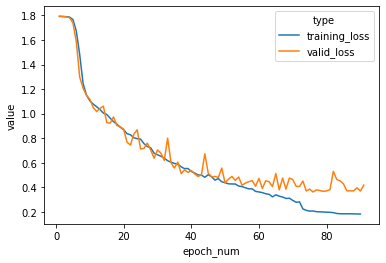

In [33]:
import seaborn as sns
sns.lineplot(data=combined_df,x='epoch_num', y='value', hue='type')

As seen above, training was stopped when validation loss plateaued, which prevented overfitting. The learning rate scheduler also helped to reduce learning rate to reduce the fluctuation in validation loss towards the end and avoid overshooting the loss minimum.